In [20]:
from itertools import product, permutations
from functools import reduce
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse,
    geom_boxplot,
    labs,
    theme_minimal,
    theme_linedraw,
    geom_dotplot,
    scale_fill_brewer
)
import polars as pl
import torch
import functorch
from sklearn import linear_model


from sngrok.fourier import slow_sn_ft_1d, slow_sn_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.groups import generate_subgroup, Symmetric
from sngrok.permutations import Permutation
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [21]:
from torch.nn.functional import relu
from copy import deepcopy

def fp_sort_key(fp):
    last_part = fp.parts[-1].strip('.pth')
    if last_part == 'full_run':
        return 2 ** 10000
    else:
        return int(last_part)


def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def if_then(pred, x0, x1):
    return pl.when(pred).then(pl.lit(x0)).otherwise(pl.lit(x1))


def fourier_basis_to_df(tensor, n, layer):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'layer': [layer] * len(group_col), 'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')


def fourier_stats(model_seed, ckpt_path):
    #ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    ckpt_dir = Path(ckpt_path)
    run_name = f's5_40_{model_seed}'
    S5 = Symmetric(5)

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    config = model_run['config']
    embed_dim = config['embed_dim']

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    W = model.linear.weight

    lpower_df, llinear_ft = calc_power_contributions(model.lembed.weight @ W[:, :embed_dim].T, 5)
    rpower_df, rlinear_ft = calc_power_contributions(model.rembed.weight @ W[:, embed_dim:].T, 5)
    unembed_power_df, unembed_ft = calc_power_contributions(model.unembed.weight, 5)
    num_rows = lpower_df.shape[0]
    
    lpower_df.insert_at_idx(0, pl.Series('layer', ['left_linear'] * num_rows))
    rpower_df.insert_at_idx(0, pl.Series('layer', ['right_linear'] * num_rows))
    unembed_power_df.insert_at_idx(0, pl.Series('layer', ['unembed'] * num_rows))
    power_df = pl.concat([lpower_df, rpower_df, unembed_power_df], how='vertical').melt(id_vars=['layer', 'irrep'])
    
    llinear_decomp = sn_fourier_basis(llinear_ft, S5)
    rlinear_decomp = sn_fourier_basis(rlinear_ft, S5)
    unembed_decomp = sn_fourier_basis(unembed_ft, S5)
    
    llinear_df = fourier_basis_to_df(llinear_decomp, 5, 'left_linear')
    rlinear_df = fourier_basis_to_df(rlinear_decomp, 5, 'right_linear')
    #unembed_df = fourier_basis_to_df(unembed_decomp, 5, 'unembed')
        
    
    return llinear_df, rlinear_df, power_df 


def get_linear_layer_decomp(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    #full_left_coset_df, full_right_coset_df = make_full_coset_df()
    
    checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    
    model = SnMLP.from_config(full_run['config'])
    model.load_state_dict(full_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    loss = loss_fn(logits, targets)

    linear_acts = cache['hook_linear']
    df = pl.concat(
        [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(linear_acts.shape[1])])],
        how='horizontal'
    )
    return df.select(pl.exclude(['index_left', 'index_right', 'index_target', 'in_train']))
    

In [22]:
a5_subgroups = {
    "order": 60,
    "copies": 1,
    "generators": [[(4, 0, 1, 2, 3), (2, 0, 1, 3, 4)]]
}

s4_subgroups = {
    "order": 12,
    "copies": 5,
    "generators": [
        [(0, 2, 3, 4, 1), (0, 2, 1, 3, 4)], #1 fix 0
        [(2, 1, 3, 4, 0), (2, 1, 0, 3, 4)], #2 fix 1
        [(1, 3, 2, 4, 0), (1, 0, 2, 3, 4)], #3 fix 2
        [(1, 2, 4, 3, 0), (1, 0, 2, 3, 4)], #4 fix 3
        [(1, 2, 3, 0, 4), (1, 0, 2, 3, 4)], #5 fix 4
    ]
}



In [26]:
def union(cosets):
    if len(cosets) == 0:
        return cosets
    else:
        return reduce(lambda x, y: set(x).union(set(y)), cosets)

def get_cosets(subgroup):
    S5 =  Permutation.full_group(5)
    all_s5 = set([s.sigma for s in S5])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_s5:
        left = S5.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def _coset_join(df1, df2):
    return df1.join(df2, on='permutation', how='inner')


def _coset_df(cosets, index, sg_name):
    data = []
    
    for cos in cosets:
        rep = str(cos[0])
        data.extend([{'permutation': str(c), 'subgroup': f'{sg_name}_{index}', f'coset_rep': rep} for c in cos])
    return pl.DataFrame(data)


def get_left_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        left = Sn.pop()
        coset = tuple(sorted([(left * s).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def get_right_cosets(subgroup, full_n):
    Sn =  Permutation.full_group(full_n)
    all_sn = set([s.sigma for s in Sn])
    perms = [Permutation(s) for s in subgroup]
    cosets = set()
    while union(cosets) != all_sn:
        right = Sn.pop()
        coset = tuple(sorted([(s * right).sigma for s in perms]))
        cosets.add(coset)
    return cosets



def make_left_coset_rep_df(subgroups, n, sg_name):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    
    return pl.concat(data, how='vertical')


def make_right_coset_rep_df(subgroups, n, sg_name):
    data = []
    
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    
    return pl.concat(data, how='vertical')



def make_right_full_coset_df(subgroups, n, sg_name):
    data = []
    for i, sg in enumerate(subgroups):
        cosets = list(get_right_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    return pl.concat(data, how='vertical')


def make_left_full_coset_df(subgroups, n, sg_name):
    data = []
    for i, sg in enumerate(subgroups):
        cosets = list(get_left_cosets(sg, n))
        data.append(_coset_df(cosets, i, sg_name))
    return pl.concat(data, how='vertical')


In [27]:
your_path = '/Users/dashiell/workspace/sn-grok/s5_40_small'

llinear_df, rlinear_df, power_df = fourier_stats(5, your_path)
left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
linear_df = get_linear_layer_decomp(5)

In [35]:
all_s4 = [generate_subgroup(gens) for gens in s4_subgroups['generators']] 
all_a5 = [generate_subgroup(gens) for gens in a5_subgroups['generators']]


s4_left_coset_df = make_left_coset_rep_df(all_s4, 5, 's4')
s4_right_coset_df = make_right_coset_rep_df(all_s4, 5, 's4')

a5_coset_df = make_left_coset_rep_df(all_a5, 5, 'a5')


## Sign Circuit Graphs

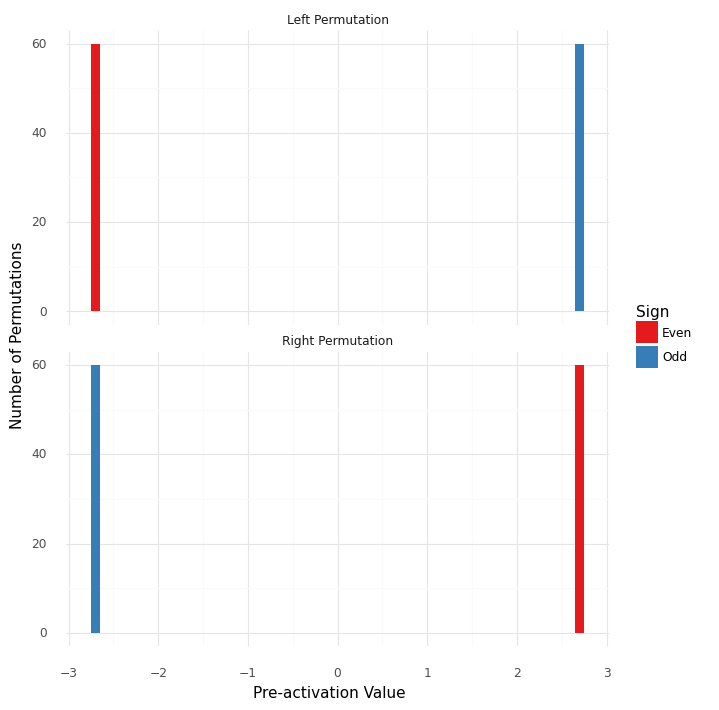

<ggplot: (688097262)>

In [40]:
dfl = (
    left_base_df
    .filter(pl.col('variable') == 'dim16')
    .join(a5_coset_df, on='permutation')
    .with_columns(if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'))
)
dfr = (
    right_base_df
    .filter(pl.col('variable') == 'dim16')
    .join(a5_right_coset_df, on='permutation')
    .with_columns(
        if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'))
)
dfl.insert_at_idx(0, pl.Series('side', ['Left Permutation'] * 120))
dfr.insert_at_idx(0, pl.Series('side', ['Right Permutation'] * 120))

df = pl.concat([dfl, dfr], how='vertical')


fig = (
    ggplot(df, aes(x='value', fill='sign')) 
    + geom_histogram(binwidth=0.1) 
    + facet_wrap('~side', nrow=2)
    + labs(y = "Number of Permutations", x = "Pre-activation Value", fill="Sign")
    + theme_minimal()
    + theme(figure_size=(7,8))
    + scale_fill_brewer('qual', 6)
)
fig

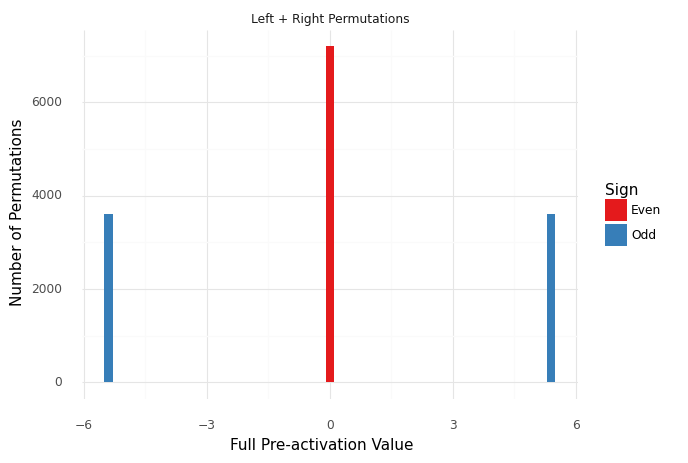

<ggplot: (688086545)>

In [41]:
dflin = (
    linear_df
    .select(['permutation_target', 'dim16'])
    .join(a5_coset_df, left_on='permutation_target', right_on='permutation')
    .with_columns(
        if_then((pl.col('coset_rep') == "(0, 1, 2, 3, 4)"), "Even", "Odd").alias('sign'),
        pl.Series('layer', ['Left + Right Permutations']* 14400)
    )
)

fig = (
    ggplot(dflin, aes(x='dim16', fill = 'sign')) 
    + geom_histogram(binwidth=0.2)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Pre-activation Value", fill="Sign")
    + theme_minimal()
    + scale_fill_brewer('qual', 6)
)
fig

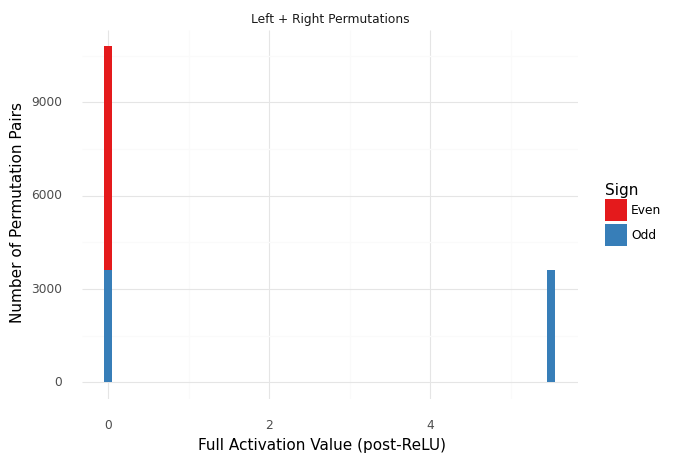

<ggplot: (688185299)>

In [42]:
fig = (
    ggplot(dflin.with_columns(pl.col('dim16').clip_min(0)), aes(x='dim16', fill = 'sign')) 
    + geom_histogram(binwidth=0.1)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutation Pairs", x = "Full Activation Value (post-ReLU)", fill="Sign")
    + theme_minimal()
    + scale_fill_brewer('qual', 6)
)
fig

## S_4 Circuit Graphs

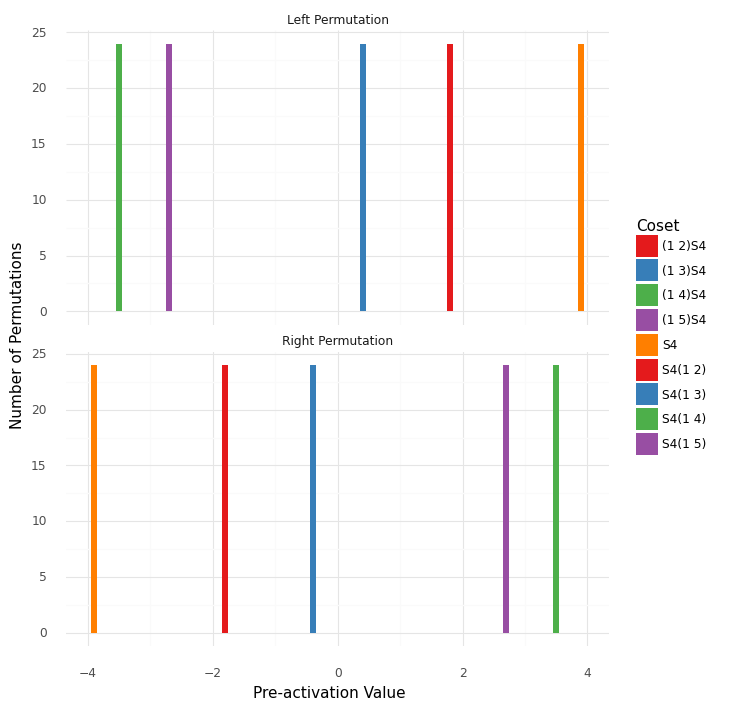

<ggplot: (301659082)>

In [39]:
from mizani.palettes import brewer_pal
from plotnine import scale_fill_manual



left_coset_rename = {
    '(0, 1, 2, 3, 4)': 'S4',
    '(1, 0, 2, 3, 4)': '(1 2)S4',
    '(1, 2, 0, 3, 4)': '(1 3)S4',
    '(1, 2, 3, 0, 4)': '(1 4)S4',
    '(1, 2, 3, 4, 0)': '(1 5)S4',

}

right_coset_rename = {
    '(0, 1, 2, 3, 4)': 'S4',
    '(1, 0, 2, 3, 4)': 'S4(1 2)',
    '(2, 0, 1, 3, 4)': 'S4(1 3)',
    '(3, 0, 1, 2, 4)': 'S4(1 4)',
    '(4, 0, 1, 2, 3)': 'S4(1 5)'

}


dfl = (
    left_base_df
    .filter(pl.col('variable') == 'dim23')
    .join(s4_right_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(right_coset_rename))
)
dfr = (
    right_base_df
    .filter(pl.col('variable') == 'dim23')
    .join(s4_left_coset_df.filter(pl.col('subgroup') == 's4_0'), on='permutation')
    .with_columns(pl.col('coset_rep').map_dict(left_coset_rename))
    
)
dfl.insert_at_idx(0, pl.Series('side', ['Left Permutation'] * 120))
dfr.insert_at_idx(0, pl.Series('side', ['Right Permutation'] * 120))

df = pl.concat([dfl, dfr], how='vertical')

palette = brewer_pal('qual', 6)(5)

colors = palette + palette[:-1]


fig = (
    ggplot(df, aes(x='value', fill='coset_rep')) 
    + geom_histogram(binwidth=0.1) 
    + facet_wrap('~side', nrow=2)
    + labs(y = "Number of Permutations", x = "Pre-activation Value", fill="Coset")
    + theme_minimal()
    + theme(figure_size=(7,8))
    + scale_fill_manual(values = colors)
)

fig

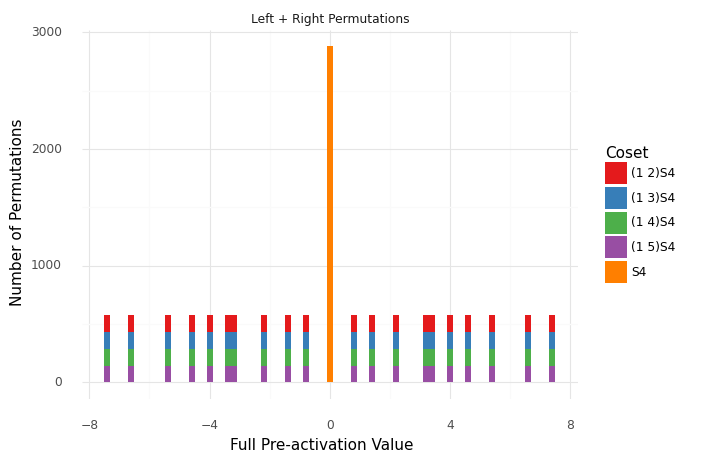

<ggplot: (301776933)>

In [43]:

dflin = (
    linear_df
    .select(['permutation_target', 'dim23'])
    .join(s4_left_coset_df.filter(pl.col('subgroup') == 's4_0'), left_on='permutation_target', right_on='permutation')
    .with_columns(
        pl.Series('layer', ['Left + Right Permutations']* 14400),
        pl.col('coset_rep').map_dict(left_coset_rename)
    )
)

fig = (
    ggplot(dflin, aes(x='dim23', fill = 'coset_rep')) 
    + geom_histogram(binwidth=0.2)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Pre-activation Value", fill="Coset")
    + theme_minimal()
    + scale_fill_brewer(type='qual', palette=6)
)
fig

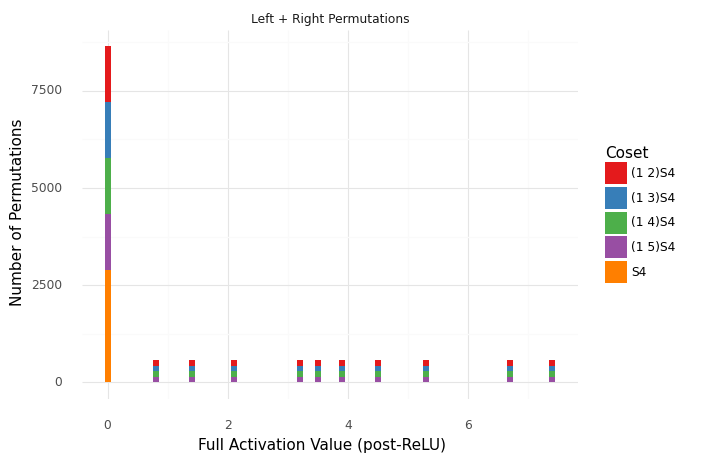

<ggplot: (301068685)>

In [44]:
fig = (
    ggplot(dflin.with_columns(pl.col('dim23').clip_min(0)), aes(x='dim23', fill = 'coset_rep')) 
    + geom_histogram(binwidth=0.1)
    + facet_wrap('~layer')
    + labs(y = "Number of Permutations", x = "Full Activation Value (post-ReLU)", fill="Coset")
    + theme_minimal()
    +  scale_fill_brewer(type='qual', palette=6)
)
fig